# Introduction to PyTorch

Modern deep learning typically builds on one of the major libraries that allow to efficiently build models without having to deal with the underlying infrastructure and computations.
In particular, they free us from the burden of calculating all the mathematical formulae (mostly linear algebra) to train the network, and to do so efficiently on modern GPUs.

Mostly, two libraries are used: [PyTorch](https://pytorch.org/), developed by Meta/Facebook, or [TensorFlow](https://www.tensorflow.org/), developed by Alphabet/Google. As you can see, a lot of AI research is no longer driven by academia, but industry. Each of these libraries have their strenghts and weaknesses. However, the choice will not limit you in what you can do (maybe how easy it is to implement something). We will choose PyTorch in this course as it has emerged in recent years as them most used package in research, both in academia and industry.

Before we will use this library to do any deep learning, we will first cover the basics - using the humble linear regression as an example. Of course, this is efficiently provided by [Linear Regression in Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), however, it serves as an example to:
- see what is going on step by step
- remind ourselves that, in the end, these libraries are also powerful optimisation libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.optim as optim

# Generate data

We will generate some dummy data. Essentially, we want to fit a straight line: We generate data according to a straight line and add some white (Gaussian) noise:
$$
y \sim m*x + b + \mathcal{N(0,1)}
$$

In [2]:
m_true = 3
b_true = 1
eps = 0.1

n_samples = 100
std_dev = 1
x = np.random.rand(n_samples, std_dev)
y = m_true * x + b_true + eps * np.random.randn(n_samples, std_dev)

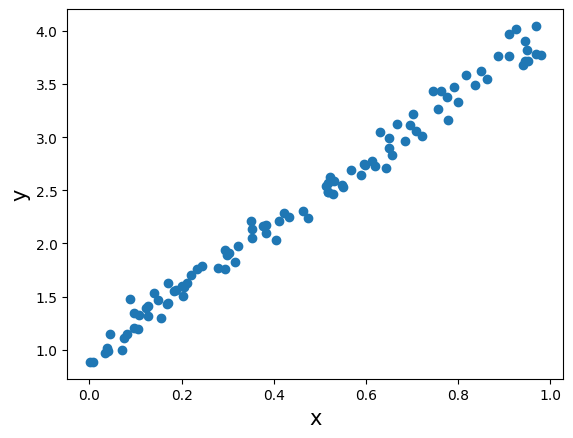

In [3]:
plt.scatter(x,y)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.show()

# Initialise

Before we initialise PyTorch, we need to find out if we have a CPU or a GPU available. For this simple example, a CPU is sufficient - but if we do have a GPU, we need to "move" all data and models to it.

We do this by checking if CUDA is available (not just installed), i.e. if there are NVidia graphics drivers.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


Internally, PyTorch works with [Torch.Tensor](https://pytorch.org/docs/stable/tensors.html) as numeric data types, see also [PyTorch: Tensor](https://pytorch.org/tutorials/beginner/examples_tensor/polynomial_tensor.html).

In a sense, they are quite similar to a multidimensional [NumPy Array](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html). One major difference is that these tensors can be used both on CPU and on GPU. We can also specify the data type.

Therefore, to be able to use PyTorch, we need to convert our data to these tensors. Since we started from NumPy, we can use a convenience function provided by PyTorch to do this.
We need to do the following steps:
- convert the data from numpy array to PyTorch tensor
- specify the data type
- move the data to the device we want to run on.

The latter step is a crucial detail if we want to make use of, for example, a GPU: If we forget to move either the data or the model to the GPU, we cannot utilise it.
Note that we can chain the commands to make the code a bit more efficient

In [5]:
#
# convert the NumPy arrays with the data from above to PyTorch tensors
#
x_tensor = torch.from_numpy(x).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)

print(x_tensor.shape,y_tensor.shape)
print(x_tensor.type(),y_tensor.type())

torch.Size([100, 1]) torch.Size([100, 1])
torch.FloatTensor torch.FloatTensor


In this case where we want to fit a linear regression model, we have two variables that we need to fit: the slope and the intercept of the line.

Therefore, we need to define two variables that we use in the fitting.
We initialise these variables using a standard Gaussian, so that they have well-defined and not pathological values. We can do so using [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html)

We need to specify a few parameters:
- ```size```: the size of the array. Here: 1, as we need a single number
- ```requires_grad = True```: to be able to use this in the minimisation/fitting procedure
- ```dtype```: here we use ```torch.float``` as all our variables are floating point variables
-```device``` we need to make sure that we "move" the model to the device we are using, i.e. either a CPU or  a GPU.

Finally, we print the tensors. Note that this gives us quite a bit of information: They are indeed of the datatype "tensor", hold a single value in array shape and are used during optimisation.

We can get the shape of the array also directly.

In [6]:
#
# define Torch variables - if a GPU is available, use this for the computation
# indicate that these variables will be optimized using gradient descent
#

m = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(m, b)
print(m.shape, b.shape)

tensor([-0.6942], requires_grad=True) tensor([-0.2415], requires_grad=True)
torch.Size([1]) torch.Size([1])


# Model fit

Now we need to fit the model, i.e. our straigt line.

We need the following ingredients to do so:
- an optimiser with suitable parameters
- an error metric

The optimizer is the algorithm that determines how to change the values of the parameters in our model (here: slope $m$ and intercept $b$) such that the resuling straight line fits "better" to the data we want to fit. This is then quantified by a loss (or: error) function.

In our case, we use [Stochastic Gradient Descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) as optimiser. This is one of the simpler algorithms - it will work well in this case, but we would choose others in more involved applications. This optimiser needs at least the following parameters:
- learn rate: How big the steps are in each iteration when estimating new parameters
- number of epochs: the number of times we want to run the optimiser. Unfornately, we cannot just say "run until it's done" but need to specify, in the simplest approach, how long we want to run for and then determine if this was sufficient.

Further, we use the means squared error (MSE) as loss function, i.e. the difference between the predicted ($\hat{y}$) and true value ($y$):
$$
MSE = \frac{1}{N}\sum_i (\hat{y} -  y)^2
$$

In this simple example, we do everything manually and step through the fitting. Later, when we define deep learning models, much of this will be done by helper functions.

In [7]:
#
# Fit the model
#

learn_rate = 1e-1
n_epochs = 1000

# define the optimiser used to learn the parameters
# (Gradient descent)
optimiser = optim.SGD([m, b], lr=learn_rate)

loss_array = []
# training loop
for epoch in range(n_epochs):

  # prediction
  y_hat =  m * x_tensor + b

  # use MSE as loss function
  error = y_tensor - y_hat
  loss = (error ** 2).mean()
  loss_array.append(loss.detach().numpy())


  # this computes the gradient of the loss function
  # i.e. d(loss)/dx
  loss.backward()   

  # use the gradient to update the values of the parameters
  optimiser.step()

  # clears the computations of the gradients
  optimiser.zero_grad()

print('slope:', m, 'true slope: ', m_true)
print('intercept: ', b, 'true intercept: ', b_true)

slope: tensor([3.0539], requires_grad=True) true slope:  3
intercept:  tensor([0.9541], requires_grad=True) true intercept:  1


Next, we look at the values of the loss function during the optimisation.
As we can see, starting from the random values above, we make a big jump in the first few iterations, then the progress is much smaller.

However, looking at the plot on a log-scale, we can see that after the initial jump in the first iterations, there is a steady decline over the next about 200 iterations, and only after about 300 iterations or so we start to run into a plateau.

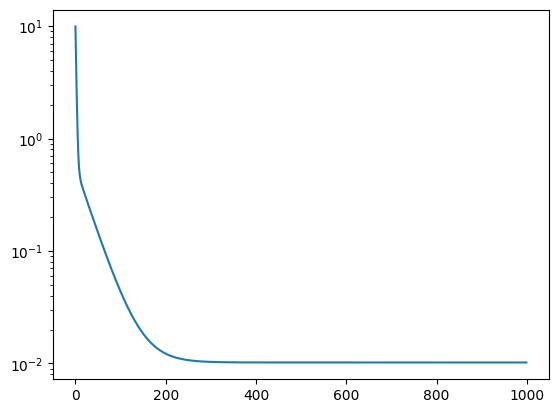

In [8]:
plt.plot(loss_array)
plt.yscale('log')
plt.show()

Finally, we compare the fitted model with our original data, as well as the "true" slope and intercept we have generated the data from.

Note that in order to be able to do this, we first need to "de-tensorfy" the variables. Behind the scenes, PyTorch uses a computational graph to do all calculations, if we want to use the variables, e.g. for plotting, we need to [detach](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html) the variable from this graph. Further, we need to convert this back into numpy format to be able to plot the data.

For the plot, we create a number of points on the $x$-axis (```np.linspace```), and then create a straight line: $ y = m*x + b$.

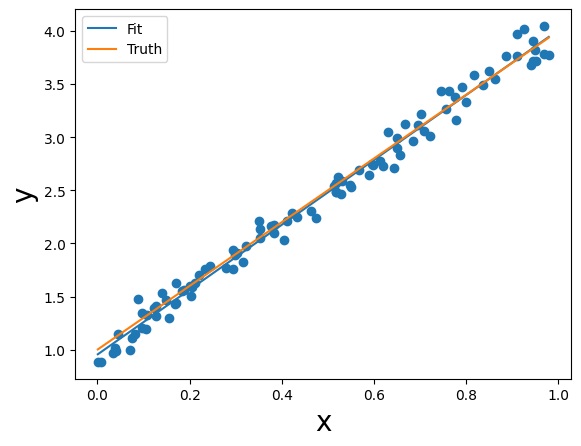

In [9]:
plt.scatter(x,y)
x_space = np.linspace(np.min(x), np.max(x))
plt.plot(x_space, m.detach().numpy()*x_space + b.detach().numpy(), label='Fit')
plt.plot(x_space, m_true*x_space +b_true, label='Truth')
plt.legend()
plt.xlabel('x', fontsize = 20)
plt.ylabel('y', fontsize = 20)
plt.show()